## Carregar o dataset e as libs necessárias

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")

In [48]:
data = pd.read_csv('sao-paulo-properties-april-2019.csv')

In [49]:
data

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13635,265000,420,51,2,1,0,1,0,0,0,0,Jabaquara/São Paulo,sale,apartment,-23.653004,-46.635463
13636,545000,630,74,3,2,1,2,0,0,1,0,Jabaquara/São Paulo,sale,apartment,-23.648930,-46.641982
13637,515000,1100,114,3,3,1,1,0,0,1,0,Jabaquara/São Paulo,sale,apartment,-23.649693,-46.649783
13638,345000,48,39,1,2,1,1,0,1,1,0,Jabaquara/São Paulo,sale,apartment,-23.652060,-46.637046


## AED do dataset

In [50]:
data['Negotiation Type'].value_counts()

Negotiation Type
rent    7228
sale    6412
Name: count, dtype: int64

### Filtrar apenas para o tipo de negociacao "sale" - imóveis a venda

In [51]:
df = data[data['Negotiation Type'] == 'sale']

In [52]:
df

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552129,-46.692244
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.551613,-46.699106
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo,sale,apartment,-23.547687,-46.692594
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552590,-46.691104
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.553087,-46.697890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13635,265000,420,51,2,1,0,1,0,0,0,0,Jabaquara/São Paulo,sale,apartment,-23.653004,-46.635463
13636,545000,630,74,3,2,1,2,0,0,1,0,Jabaquara/São Paulo,sale,apartment,-23.648930,-46.641982
13637,515000,1100,114,3,3,1,1,0,0,1,0,Jabaquara/São Paulo,sale,apartment,-23.649693,-46.649783
13638,345000,48,39,1,2,1,1,0,1,1,0,Jabaquara/São Paulo,sale,apartment,-23.652060,-46.637046


In [53]:
df.shape

(6412, 16)

### Verificar a proporção dos imóveis a venda

In [54]:
percent_builds_rent = len(df)/len(data)
print(f'Os imoveis que estão disponiveis para comprar representa certa de {percent_builds_rent*100:.2f}% da base de dados.')

Os imoveis que estão disponiveis para comprar representa certa de 47.01% da base de dados.


### Analisar mais informações sobre as variáveis disponíveis

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6412 entries, 4901 to 13639
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             6412 non-null   int64  
 1   Condo             6412 non-null   int64  
 2   Size              6412 non-null   int64  
 3   Rooms             6412 non-null   int64  
 4   Toilets           6412 non-null   int64  
 5   Suites            6412 non-null   int64  
 6   Parking           6412 non-null   int64  
 7   Elevator          6412 non-null   int64  
 8   Furnished         6412 non-null   int64  
 9   Swimming Pool     6412 non-null   int64  
 10  New               6412 non-null   int64  
 11  District          6412 non-null   object 
 12  Negotiation Type  6412 non-null   object 
 13  Property Type     6412 non-null   object 
 14  Latitude          6412 non-null   float64
 15  Longitude         6412 non-null   float64
dtypes: float64(2), int64(11), object(3)
memory 

### Analisar as estatísticas das variáveis
- Média
- Desvio padrão
- Quartis, entre outros

Tudo isso ajuda no entendimento dos dados que temos disponíveis para construir a rede neural e ajudar na previsão do modelo.

In [56]:
df.describe()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude
count,6.412000e+03,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000
mean,6.086241e+05,537.349813,78.611042,2.320805,2.037742,0.931535,1.326575,0.415471,0.117280,0.539457,0.032283,-22.127513,-43.705547
std,7.404515e+05,624.632473,50.872359,0.714743,0.917844,0.772615,0.751658,0.492841,0.321779,0.498480,0.176765,5.756660,11.271783
min,4.200000e+04,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-46.734483,-49.337815
25%,2.500000e+05,150.000000,50.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-23.592848,-46.673526
50%,3.800000e+05,400.000000,62.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-23.549693,-46.628506
75%,6.790000e+05,700.000000,87.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,-23.512534,-46.533612
max,1.000000e+07,8920.000000,620.000000,6.000000,7.000000,6.000000,7.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000


#### Preço médio dos imóveis a venda

In [57]:
# média dos preços dos imóveis
media_dos_imoveis = round(float(df.describe()['Price']['mean']), 2)
media_dos_imoveis

608624.14

#### Analisar as distribuições de forma geral das variáveis

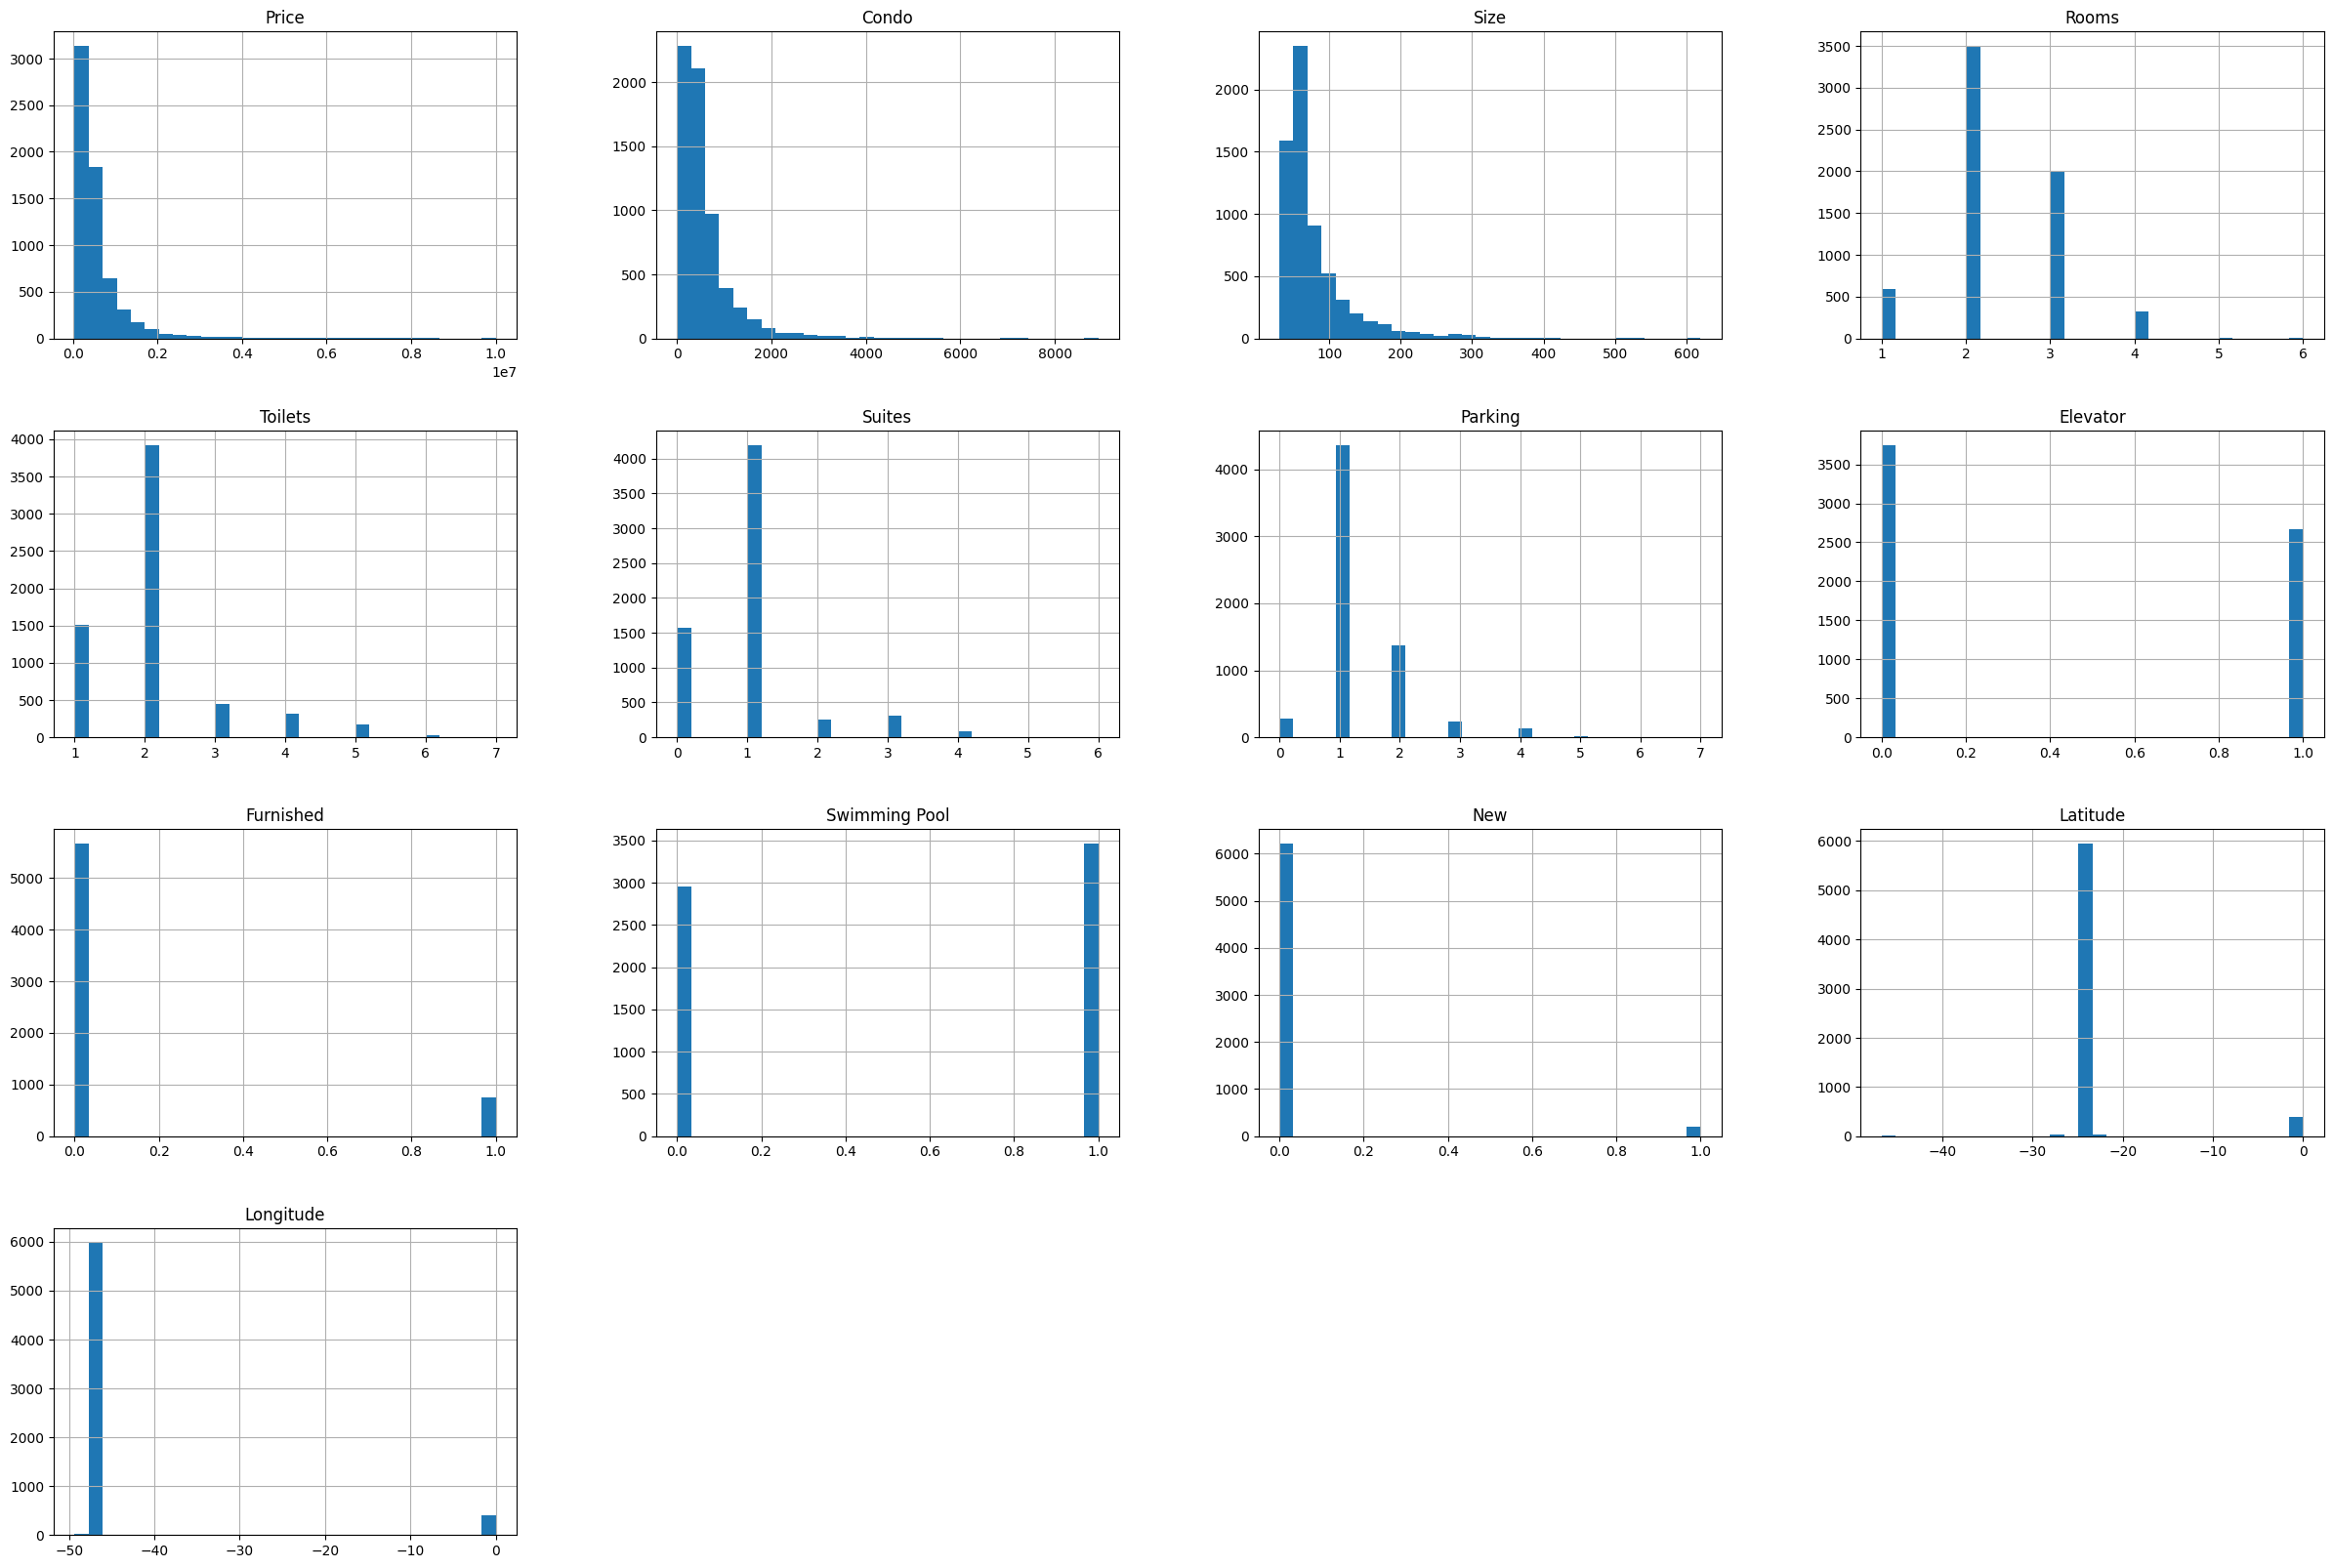

In [58]:
df.hist(bins=30, figsize=(30,20))
plt.show()

#### Os preços mais comuns dos imóveis - Top 5

In [59]:
df['Price'].value_counts().head()

Price
250000    97
240000    94
350000    93
320000    80
280000    80
Name: count, dtype: int64

#### Preço médio dos preços mais comuns dos imóveis - Top 5

In [60]:
# media de preco do top5 imoveis
float(df['Price'].value_counts().reset_index().head()['Price'].mean())

288000.0

A média de preço do top 5 imovéis dentro do conjunto de dados é de R$ 288.000,00

#### Verificar a distribuição dos preços dos imóveis a venda

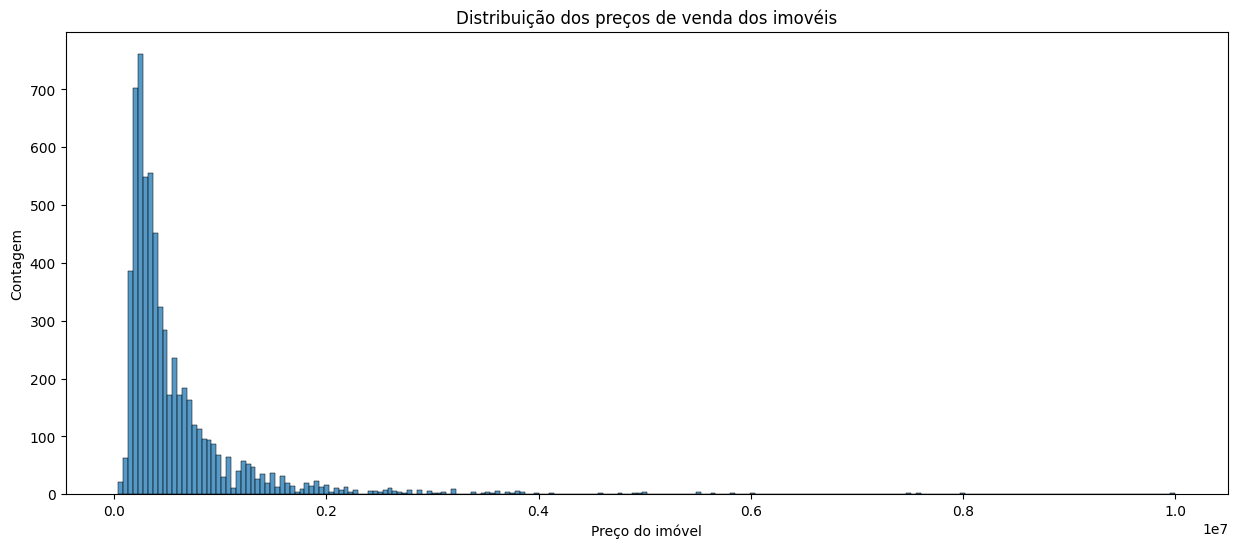

In [61]:
plt.figure(figsize=(15,6))
sns.histplot(df['Price'])
plt.title('Distribuição dos preços de venda dos imovéis')
plt.xlabel('Preço do imóvel')
plt.ylabel('Contagem')
plt.show()

#### Verificar quantos imóveis exitem abaixo do preço médio geral

In [62]:
# quantidade de imoveis abaixo da media geral de preço
quantidade_imoveis_abaixo_avg = len(df.loc[df['Price'] <= media_dos_imoveis]['Price'])
print('Quantidade de imóvesi abaixo da média geral de preço:', quantidade_imoveis_abaixo_avg)

Quantidade de imóvesi abaixo da média geral de preço: 4551


#### Verificar a proporção dos imóveis que estão abaixo do preço médio geral

In [63]:
# verificando a proporção da quantidade de imóveis abaixo a da média geral
proporcao_imoveis_abaixo_avg = round((quantidade_imoveis_abaixo_avg / df.shape[0])*100, 2)
print(f'Proporção da quantidade de imóveis abaixo da média geral: {proporcao_imoveis_abaixo_avg}%')

Proporção da quantidade de imóveis abaixo da média geral: 70.98%


> Cerca de 71% dos imóveis disponíveis para a venda estão abaixo da média geral. Enfatizando a distribuição dos preços no histograma acima.

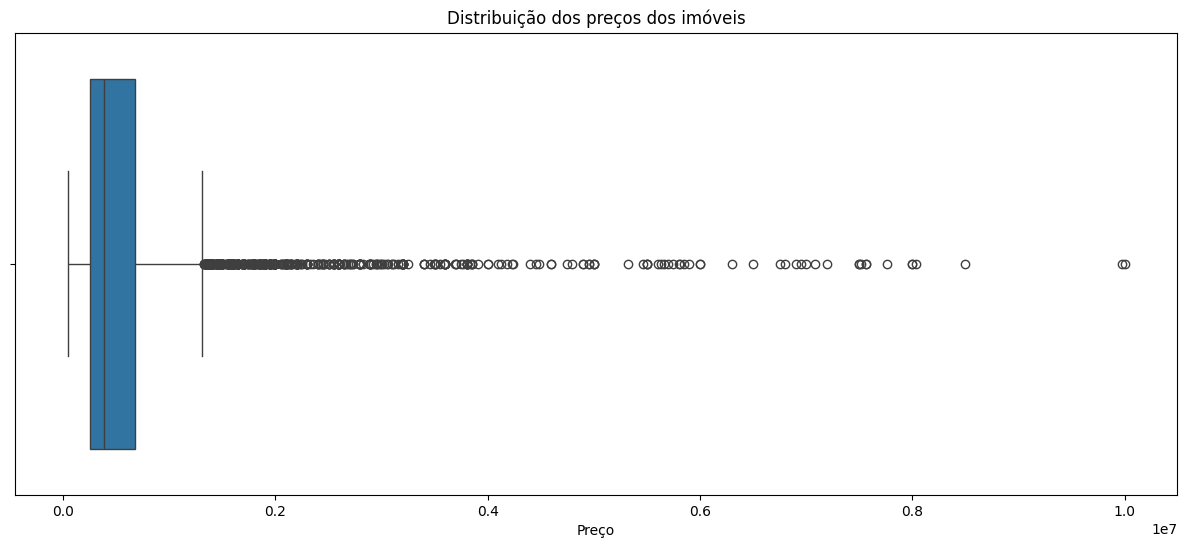

In [64]:
plt.figure(figsize=(15,6))
sns.boxplot(df['Price'], orient='h')
plt.title('Distribuição dos preços dos imóveis')
plt.xlabel('Preço')
plt.show()

Existem muitos valores outliers. É necessário tratá-los para não prejudicar o treinamento da rede.

In [65]:
df.describe()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude
count,6.412000e+03,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000
mean,6.086241e+05,537.349813,78.611042,2.320805,2.037742,0.931535,1.326575,0.415471,0.117280,0.539457,0.032283,-22.127513,-43.705547
std,7.404515e+05,624.632473,50.872359,0.714743,0.917844,0.772615,0.751658,0.492841,0.321779,0.498480,0.176765,5.756660,11.271783
min,4.200000e+04,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-46.734483,-49.337815
25%,2.500000e+05,150.000000,50.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-23.592848,-46.673526
50%,3.800000e+05,400.000000,62.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-23.549693,-46.628506
75%,6.790000e+05,700.000000,87.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,-23.512534,-46.533612
max,1.000000e+07,8920.000000,620.000000,6.000000,7.000000,6.000000,7.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000


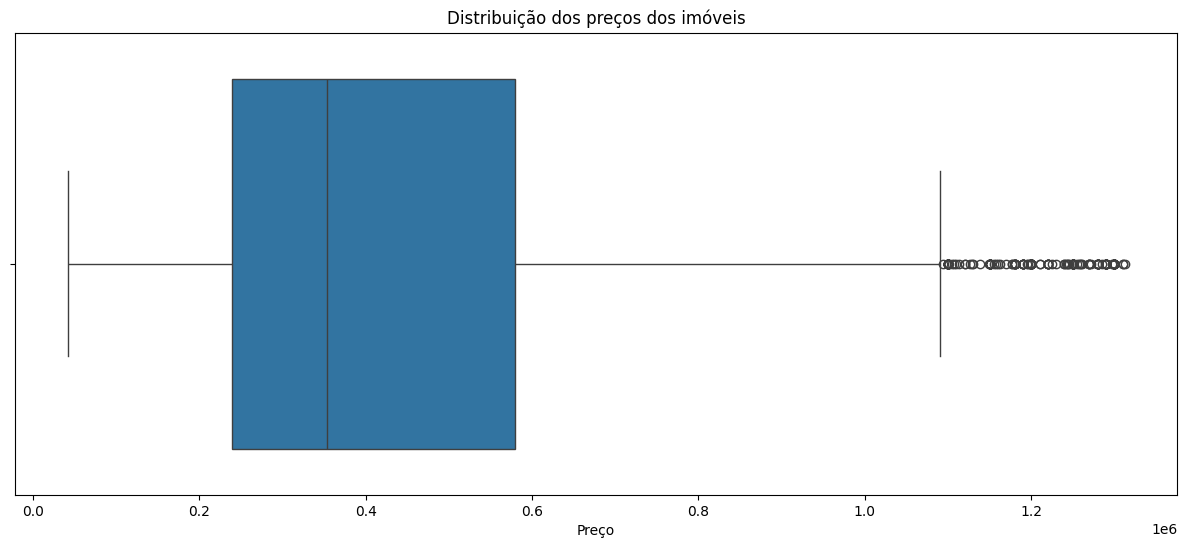

In [66]:
# Calcular o primeiro e terceiro quartil
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1

# Definir limites para remoção de outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar os dados removendo os outliers
df = df[(df["Price"] >= limite_inferior) & (df["Price"] <= limite_superior)]

plt.figure(figsize=(15,6))
sns.boxplot(df['Price'], orient='h')
plt.title('Distribuição dos preços dos imóveis')
plt.xlabel('Preço')
plt.show()


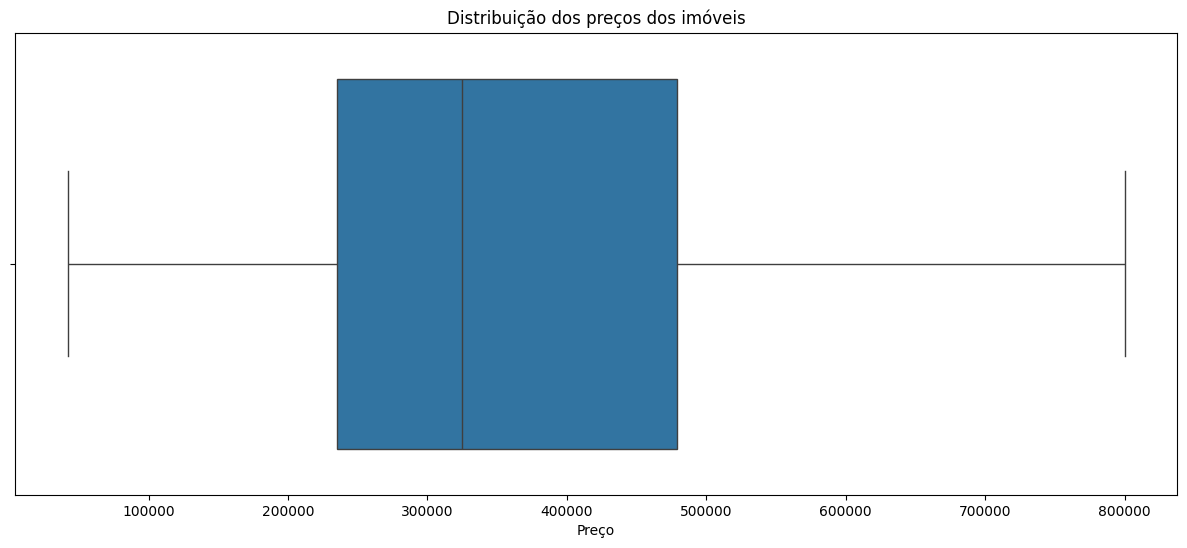

In [67]:
df = df[df["Price"] <= 800_000]
plt.figure(figsize=(15,6))
sns.boxplot(df['Price'], orient='h')
plt.title('Distribuição dos preços dos imóveis')
plt.xlabel('Preço')
plt.show()

#### Analisar a distribuição dos preços pelos distritos na cidade de São Paulo

In [68]:
df['District'].value_counts()

District
Bom Retiro/São Paulo         139
Casa Verde/São Paulo         133
Brás/São Paulo               127
Jaçanã/São Paulo             118
Liberdade/São Paulo          109
                            ... 
Jardim Paulista/São Paulo     12
Vila Olimpia/São Paulo        11
Vila Madalena/São Paulo       11
Itaim Bibi/São Paulo          10
Iguatemi/São Paulo             3
Name: count, Length: 96, dtype: int64

In [69]:
# quantidade de distritos unicos
df['District'].nunique()

96

### Analisar correlação entre as variáveis
Antes de treinar nosso modelo de previsão de preços de imóveis, é essencial entender como as variáveis do nosso conjunto de dados se relacionam entre si, especialmente em relação a variável target (Price).

A correlação nos ajuda a identificar:

- Quais variáveis têm maior impacto no preço do imóvel (correlação forte positiva ou negativa).
- Quais variáveis podem ser redundantes (altamente correlacionadas entre si, podendo causar multicolinearidade).
- Quais variáveis podem ter pouca ou nenhuma influência direta no preço (correlação próxima de 0).

In [70]:
df.loc[:, ~df.columns.isin(['District', 'Negotiation Type', 'Property Type'])].corr()['Price'].sort_values(ascending=False)

Price            1.000000
Size             0.664344
Condo            0.544563
Parking          0.475796
Rooms            0.372945
Toilets          0.361657
Swimming Pool    0.299823
Suites           0.285767
Furnished        0.123122
Elevator         0.096904
New             -0.050039
Latitude        -0.086995
Longitude       -0.088911
Name: Price, dtype: float64

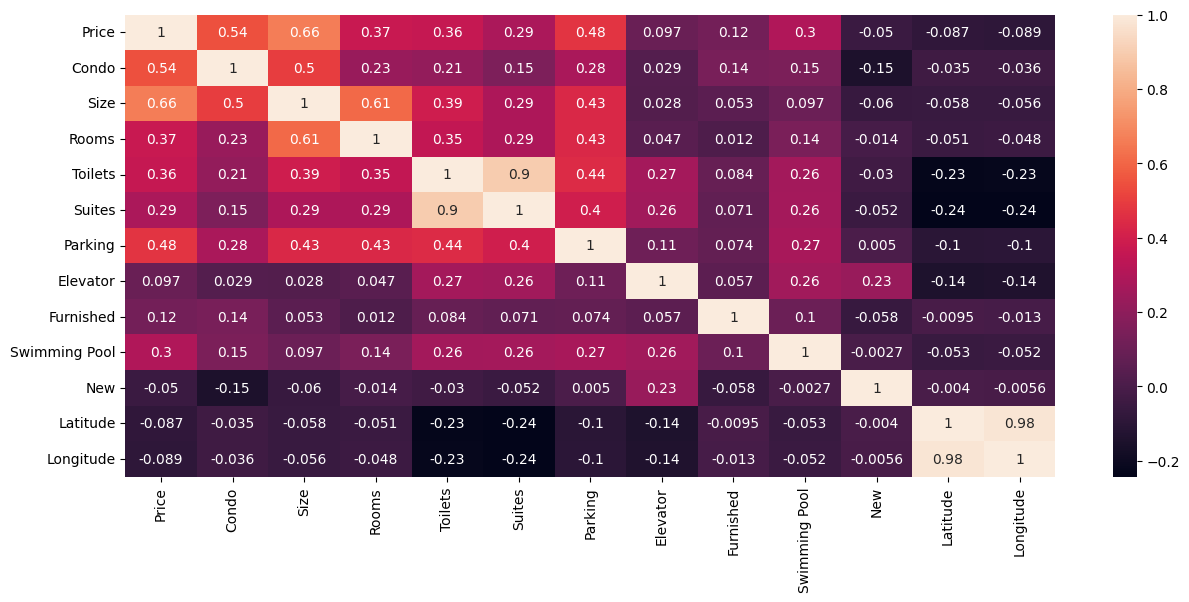

In [71]:
plt.figure(figsize=(15,6))
sns.heatmap(df.loc[:, ~df.columns.isin(['District', 'Negotiation Type', 'Property Type'])].corr(), annot=True)
plt.show()

Temos boas variáveis correlacionando com a target. Entretanto, precisamos verificar as variáveis de geolocalização. Para que possamos ter mais precisão e menos ruído no treinamento, porém sem perder essa informação de localização, vamos utilizar o KMeans e fazer uma clusterização geográfica para reduzir a dimensionalidade com o objetivo de agrupar os imóveis em regiões ou zonas.

## Tratamento dos dados

In [72]:
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552129,-46.692244
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo,sale,apartment,-23.547687,-46.692594
4911,720000,900,73,2,2,1,1,1,0,0,0,Vila Madalena/São Paulo,sale,apartment,-23.544957,-46.693206
4913,650000,0,67,2,2,1,1,1,0,0,1,Vila Madalena/São Paulo,sale,apartment,-23.562150,-46.692518
4916,697400,500,67,3,2,1,1,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.544082,-46.690373


In [73]:
df = df.drop(['Negotiation Type', 'Property Type', 'Latitude', 'Longitude', 'District'], axis=1)
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New
4901,732600,1000,74,1,2,1,2,1,0,1,0
4903,720000,700,70,2,2,1,1,1,0,1,1
4911,720000,900,73,2,2,1,1,1,0,0,0
4913,650000,0,67,2,2,1,1,1,0,0,1
4916,697400,500,67,3,2,1,1,1,0,1,0


## Preparação de dados para modelos de ML

In [74]:
df['Price'] = np.log1p(df['Price'])

In [75]:
X = df.drop('Price', axis=1)
X

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New
4901,1000,74,1,2,1,2,1,0,1,0
4903,700,70,2,2,1,1,1,0,1,1
4911,900,73,2,2,1,1,1,0,0,0
4913,0,67,2,2,1,1,1,0,0,1
4916,500,67,3,2,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
13635,420,51,2,1,0,1,0,0,0,0
13636,630,74,3,2,1,2,0,0,1,0
13637,1100,114,3,3,1,1,0,0,1,0
13638,48,39,1,2,1,1,0,1,1,0


In [76]:
y = df['Price'].values.reshape(-1, 1)
y

array([[13.50435649],
       [13.48700788],
       [13.48700788],
       ...,
       [13.15192412],
       [12.75130259],
       [11.99527754]], shape=(5225, 1))

#### Pré-processador para normalizar variáveis numéricas e codificar as variáveis categóricas

In [77]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), X.columns),
])

In [78]:
X_processed = preprocessor.fit_transform(X)

In [79]:
# Normalizar os valores y (target) para melhor convergencia da rede
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y)

## Treinamento de modelos

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_scaled, test_size=0.2, random_state=42)

In [81]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [82]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Definir o modelo da rede neural para previsão dos preços dos imóveis

In [83]:
class HousePriceNN(nn.Module):
    def __init__(self, input_size):
        super(HousePriceNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

#### Inicializar o modelo

In [84]:
input_dim = X_train.shape[1]
model = HousePriceNN(input_dim)

#### Definir a loss function e o optimizer

In [85]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.005)

#### Treinamento

In [ ]:
epochs = 300
for epoch in range(epochs):
    for batch in train_loader:
        X_batch, y_batch = batch
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    if epoch % 20 == 0:
        print(f'Época [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Época [0/300], Loss: 0.1673


In [42]:
model.eval()
y_pred = model(X_test_tensor).detach().numpy()
y_true = y_test_tensor.numpy()

In [43]:
y_pred = np.expm1(y_scaler.inverse_transform(y_pred))  # Reverte log-transform e normalização
y_true = np.expm1(y_scaler.inverse_transform(y_true))

In [44]:
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

In [45]:
print(f'R²: {r2:.4f}')
print(f'MAE: R$ {mae:.2f}')
print(f'RMSE: R$ {rmse:.2f}')

R²: 0.7380
MAE: R$ 65832.13
RMSE: R$ 90265.49


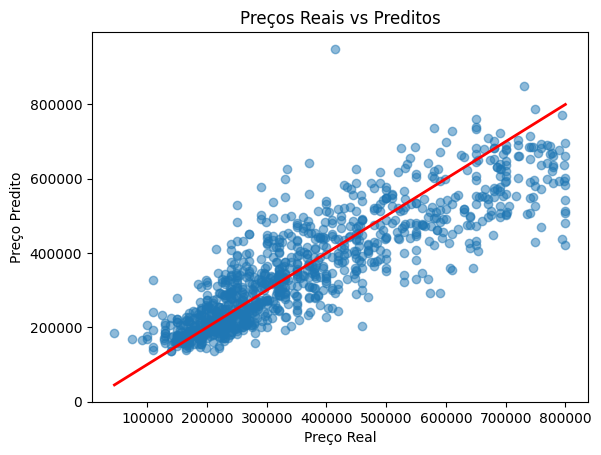

In [46]:
# plotar as previsões versus valores reais
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', lw=2)
plt.xlabel('Preço Real')
plt.ylabel('Preço Predito')
plt.title('Preços Reais vs Preditos')
plt.show()
